### Initial imports

In [2]:
import numpy as np
import pandas as pd
import os

### Importing the data 
Grab all the data from the kaggle Data library and seperate it into respective lists, converting it into greyscale and resizeing the images into 128 x 128 pixels

In [3]:
from PIL import Image
from sklearn.preprocessing import OneHotEncoder

# Initialize lists to hold the data
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []
alzheimers_labels = []

# Loop through directories and process images
for dirname, _, filenames in os.walk('/Users/jackmoses/Documents/UBC/CPEN_355/kaggle/Data/Non Demented'):
    for filename in filenames:
        img_path = os.path.join(dirname, filename)
        try:
            img = Image.open(img_path).convert('L')
            img = img.resize((128, 128))  # Resize image to 128x128
            non_demented.append(np.array(img))
            alzheimers_labels.append('non_demented')
        except Exception as e:
            print(f'Error loading image {img_path}: {e}')

for dirname, _, filenames in os.walk('/Users/jackmoses/Documents/UBC/CPEN_355/kaggle/Data/Very mild Dementia'):
    for filename in filenames:
        img_path = os.path.join(dirname, filename)
        try:
            img = Image.open(img_path).convert('L')
            img = img.resize((128, 128))  # Resize image to 128x128
            very_mild_demented.append(np.array(img))
            alzheimers_labels.append('very_mild_demented')
        except Exception as e:
            print(f'Error loading image {img_path}: {e}')

for dirname, _, filenames in os.walk('/Users/jackmoses/Documents/UBC/CPEN_355/kaggle/Data/Mild Dementia'):
    for filename in filenames:
        img_path = os.path.join(dirname, filename)
        try:
            img = Image.open(img_path).convert('L')
            img = img.resize((128, 128))  # Resize image to 128x128
            mild_demented.append(np.array(img))
            alzheimers_labels.append('mild_demented')
        except Exception as e:
            print(f'Error loading image {img_path}: {e}')

for dirname, _, filenames in os.walk('/Users/jackmoses/Documents/UBC/CPEN_355/kaggle/Data/Moderate Dementia'):
    for filename in filenames:
        img_path = os.path.join(dirname, filename)
        try:
            img = Image.open(img_path).convert('L')
            img = img.resize((128, 128))  # Resize image to 128x128
            moderate_demented.append(np.array(img))
            alzheimers_labels.append('moderate_demented')
        except Exception as e:
            print(f'Error loading image {img_path}: {e}')

# 2:40

### display the scans from each category


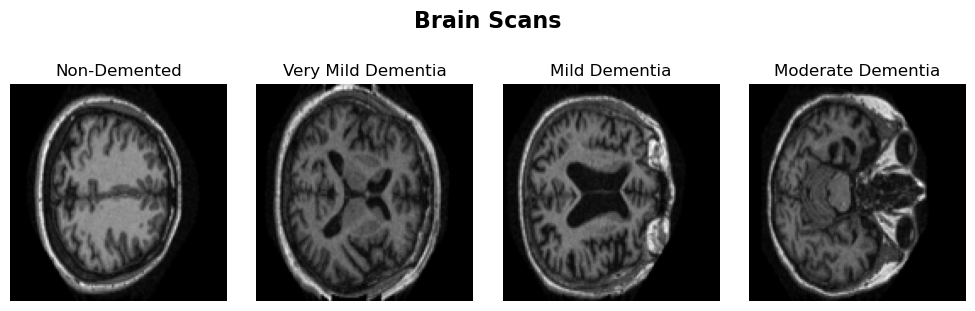

In [38]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 3))

# Add a main title
plt.suptitle('Brain Scans', fontsize=16, fontweight='bold', y=1.02)

# Subplot 1
plt.subplot(1, 4, 1)
plt.imshow(non_demented[0], cmap='gray')
plt.title('Non-Demented')
plt.axis('off')

# Subplot 2
plt.subplot(1, 4, 2)
plt.imshow(very_mild_demented[0], cmap='gray')
plt.title('Very Mild Dementia')
plt.axis('off')

# Subplot 3
plt.subplot(1, 4, 3)
plt.imshow(mild_demented[0], cmap='gray')
plt.title('Mild Dementia')
plt.axis('off')

# Subplot 4
plt.subplot(1, 4, 4)
plt.imshow(moderate_demented[0], cmap='gray')
plt.title('Moderate Dementia')
plt.axis('off')

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title
plt.show()


#### Plot to observe whether the data is balanced or unbalanced

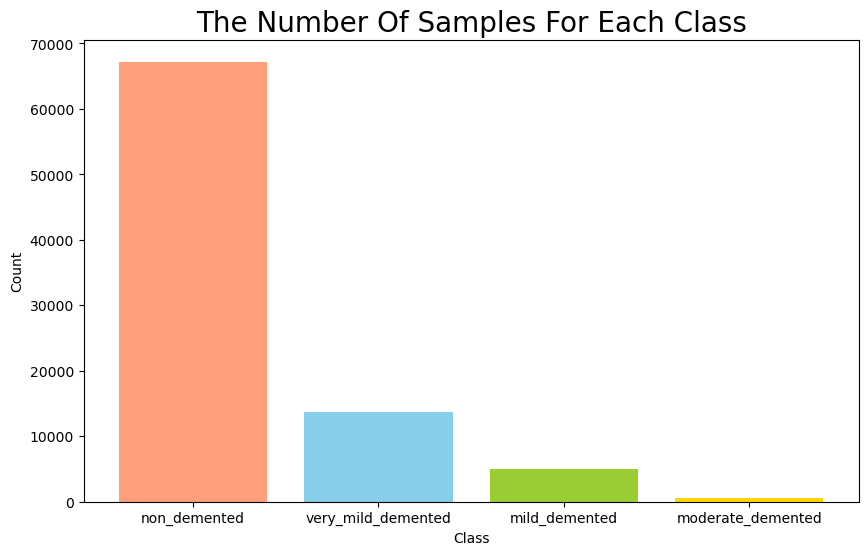

In [5]:

from collections import Counter
# Loading the data and normalizing the pixel values

# Count occurrences of each category
counter = Counter(alzheimers_labels)
categories = list(counter.keys())
counts = list(counter.values())

colours = ['#FFA07A', '#87CEEB', '#9ACD32', '#FFD700']
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=colours)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(False)
plt.show()


### Splitting the data function.

This method is used to split the data into 70% training data, 20% validation data and 10% testing data. It also normalizes the data in seperate batches to ensure that there is not too much load on the CPU which could cause the kernel to cancel.

In [6]:
from sklearn.model_selection import train_test_split
# chose different data sizes, due to the lack of balanced data set.add
# This function allows us to do different data splits to handle unbalanced data

def split_data(X, y):

    def normalize_images(X):
        # Split into batches of size 1000 or based on your memory capacity
        batch_size = 1000
        num_batches = len(X) // batch_size + 1
        
        normalized_batches = []
        for i in range(num_batches):
            batch = X[i*batch_size: (i+1)*batch_size]
            normalized_batch = batch.astype('float32') / 255.0
            normalized_batches.append(normalized_batch)
        
        return np.concatenate(normalized_batches)
            
        # initial split into 70% training data remaining 30% is used to seperate into validation and Test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=17, shuffle = True)
    # Do the secondary split 
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1/3), random_state=17, shuffle= True)
    
    X_train = normalize_images(X_train)
    X_val = normalize_images(X_val)
    X_test = normalize_images(X_test)

    return (X_train, X_val, X_test, y_train, y_val, y_test)
    


### Balancing the data set.

Based on the results of the table we observed that the data needed to be balanced in order to ensure the model doesn't overfit to one of the categories, we have decided to include 82 persons from each category if possible to train and validate the model.

In [8]:
'''
Balancing the data set so that there are the same number of images for each label/category
'''
alzheimers_images = []  # List to collect image arrays
alzheimers_labels_encoded = []  # List to collect encoded labels

# find the minimum length of the data category 
reduced_data_set_len = min(len(non_demented),len(mild_demented), len(very_mild_demented))

print(reduced_data_set_len)
# adjust the size of the data
bal_non_demented = non_demented[:reduced_data_set_len]
bal_very_mild_demented = very_mild_demented[:reduced_data_set_len]
bal_mild_demented = mild_demented[:reduced_data_set_len]
# The reduced length exceeds the size of moderate demented
bal_moderate_demented = moderate_demented

# create the data to be used for training the model
for image in bal_non_demented:
    alzheimers_images.append(image)
    alzheimers_labels_encoded.append(0)

for image in bal_very_mild_demented:
    alzheimers_images.append(image)
    alzheimers_labels_encoded.append(1)

for image in bal_mild_demented:
    alzheimers_images.append(image)
    alzheimers_labels_encoded.append(2)

for image in bal_moderate_demented:
    alzheimers_images.append(image)
    alzheimers_labels_encoded.append(3)

# After the loops, convert lists to NumPy arrays
alzheimers_images = np.array(alzheimers_images)  # Convert list to NumPy array
alzheimers_labels_encoded = np.array(alzheimers_labels_encoded)  # Stack encoded labels
# Add a channel dimension for grayscale images (shape: [num_images, 128, 128, 1])
alzheimers_images = np.expand_dims(alzheimers_images, axis=-1)

'''
Creating the data for the given balanced split
'''
bal_X_train, bal_X_val, bal_X_test, bal_y_train, bal_y_val, bal_y_test = split_data(alzheimers_images, alzheimers_labels_encoded)

print(f"Training set size: {len(bal_X_train)}")
print(f"Validation set size: {len(bal_X_val)}")
print(f"Test set size: {len(bal_X_test)}")

# 40 seconds

5002
Training set size: 10845
Validation set size: 3099
Test set size: 1550


#### Observing the balanced data set

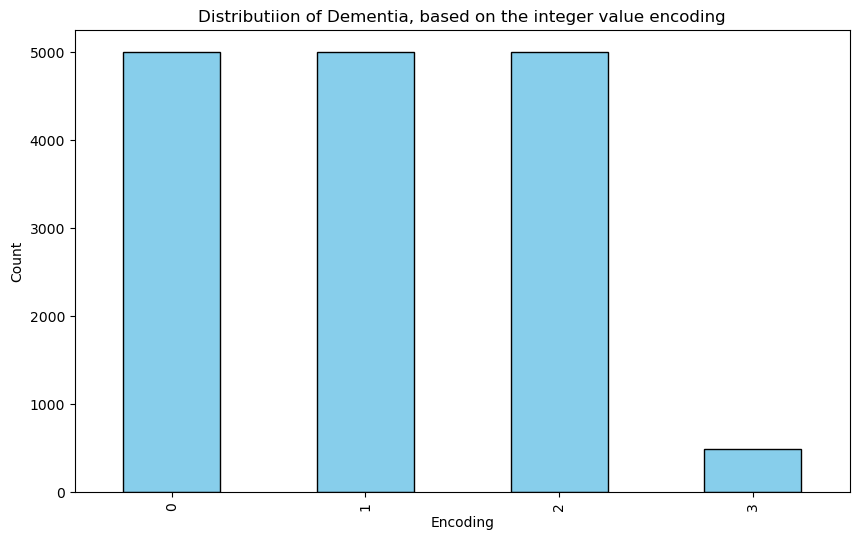

In [40]:
digit_counts = pd.array(alzheimers_labels_encoded).value_counts().sort_index()
counts_array = digit_counts.values
variance = np.var(counts_array)

# Step 3: Plot the distribution
plt.figure(figsize=(10, 6))
digit_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distributiion of Dementia, based on the integer value encoding")
plt.xlabel("Encoding")
plt.ylabel("Count")
plt.show()


### Splitting the data per patient

We have chosen to include 82 patients, this stores the images in the shape of [num_patients, 61, 128, 128], this will be used for generating the LSTM model.

In [10]:
# Initialize variables
alzheimers_images_per_patient = []
alzheimers_labels_per_patient = []

# Helper function to process a directory of images
def process_images(directory, label, images_list, labels_list, max_patients=82):
    patient_images = []
    patient_count = 0  # Track the number of patients processed
    for dirname, _, filenames in os.walk(directory):
        for filename in sorted(filenames):  # Sort files to ensure consistent grouping
            img_path = os.path.join(dirname, filename)
            try:
                img = Image.open(img_path).convert('L')
                img = img.resize((128, 128))  # Resize image to 128x128
                patient_images.append(np.array(img))
                if len(patient_images) == 61:  # Once we reach 60 images, save as one patient's data
                    images_list.append(np.array(patient_images))  # Add 60 images as one group
                    labels_list.append(label)  # Add the label for this group
                    patient_images = []  # Reset for the next patient
                    patient_count += 1
                    if patient_count >= max_patients:  # Stop if we have enough patients
                        return
            except Exception as e:
                print(f'Error loading image {img_path}: {e}')

# Process directories (limit to 8 patients per category)
process_images('/Users/jackmoses/Documents/UBC/CPEN_355/kaggle/Data/Non Demented', 0, alzheimers_images_per_patient, alzheimers_labels_per_patient)
process_images('/Users/jackmoses/Documents/UBC/CPEN_355/kaggle/Data/Very mild Dementia', 1, alzheimers_images_per_patient, alzheimers_labels_per_patient)
process_images('/Users/jackmoses/Documents/UBC/CPEN_355/kaggle/Data/Mild Dementia', 2, alzheimers_images_per_patient, alzheimers_labels_per_patient)
process_images('/Users/jackmoses/Documents/UBC/CPEN_355/kaggle/Data/Moderate Dementia', 3, alzheimers_images_per_patient, alzheimers_labels_per_patient)

# Convert to numpy arrays
alzheimers_images_per_patient = np.array(alzheimers_images_per_patient)  # Shape: [num_patients, 61, 128, 128]
alzheimers_labels_per_patient = np.array(alzheimers_labels_per_patient)  # Shape: [num_patients]
alzheimers_images_per_patient = np.expand_dims(alzheimers_images_per_patient, axis=-1)

pp_X_train, pp_X_val, pp_X_test, pp_y_train, pp_y_val, pp_y_test = split_data(alzheimers_images_per_patient, alzheimers_labels_per_patient)


## Building the models

### CNN model

In [ ]:
# Define CNN model
import tensorflow as tf
from keras import layers, models

cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')  # 4-class classification
])

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

/Users/jackmoses/miniconda3/envs/cpen355project/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,580 (12.61 MB)

 Trainable params: 3,304,580 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

#### Fit the model to the balanced training and validation data

In [12]:
from keras import callbacks

# Define early stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)


# Train the CNN model as an example
history_cnn = cnn_model.fit(bal_X_train, bal_y_train,
                        epochs=15,
                        batch_size=32,
                        validation_data=(bal_X_val, bal_y_val),
                        callbacks=[early_stopping])

# 19:16 minutes

Epoch 1/15
339/339 ━━━━━━━━━━━━━━━━━━━━ 48s 141ms/step - accuracy: 0.4845 - loss: 1.0443 - val_accuracy: 0.8638 - val_loss: 0.3920
Epoch 2/15
339/339 ━━━━━━━━━━━━━━━━━━━━ 51s 150ms/step - accuracy: 0.8696 - loss: 0.3591 - val_accuracy: 0.9435 - val_loss: 0.1584
Epoch 3/15
339/339 ━━━━━━━━━━━━━━━━━━━━ 50s 149ms/step - accuracy: 0.9380 - loss: 0.1706 - val_accuracy: 0.9468 - val_loss: 0.1350
Epoch 4/15
339/339 ━━━━━━━━━━━━━━━━━━━━ 52s 153ms/step - accuracy: 0.9628 - loss: 0.1031 - val_accuracy: 0.9732 - val_loss: 0.0800
Epoch 5/15
339/339 ━━━━━━━━━━━━━━━━━━━━ 51s 151ms/step - accuracy: 0.9756 - loss: 0.0669 - val_accuracy: 0.9774 - val_loss: 0.0608
Epoch 6/15
339/339 ━━━━━━━━━━━━━━━━━━━━ 53s 156ms/step - accuracy: 0.9841 - loss: 0.0459 - val_accuracy: 0.9858 - val_loss: 0.0425
Epoch 7/15
339/339 ━━━━━━━━━━━━━━━━━━━━ 52s 152ms/step - accuracy: 0.9871 - loss: 0.0347 - val_accuracy: 0.9810 - val_loss: 0.0590
Epoch 8/15
339/339 ━━━━━━━━━━━━━━━━━━━━ 52s 152ms/step - accuracy: 0.9850 - loss: 0

#### Plot the training and validation Accuracy and lost over each epoch to see how the model progresses

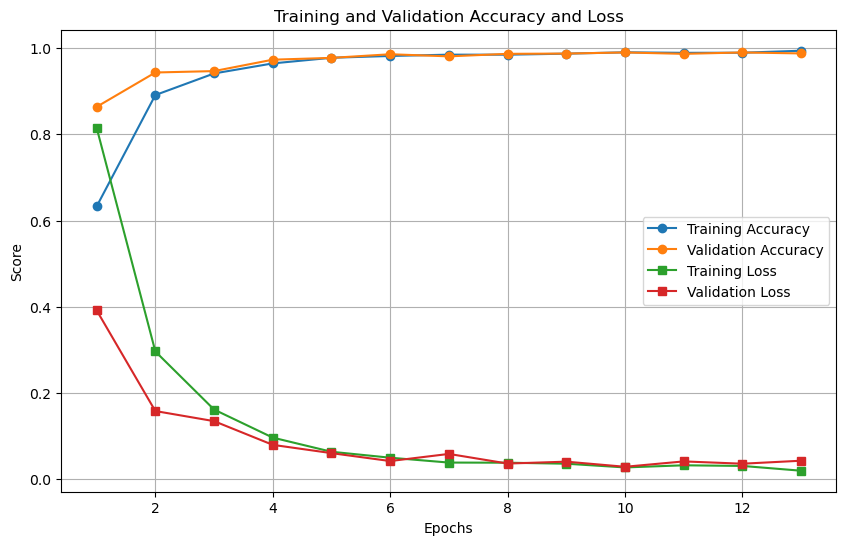

In [14]:
train_loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
train_accuracy = history_cnn.history['accuracy']
val_accuracy = history_cnn.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation accuracy and loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.plot(epochs, train_loss, label='Training Loss', marker='s')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')

plt.title('Training and Validation Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

#### Test the model and plot the confustion matrix and classification report for the CNN model

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Predict on test data
y_pred = cnn_model.predict(bal_X_test)
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(bal_y_test, y_pred_classes))

# Classification Report
print("Classification Report:")
print(classification_report(bal_y_test, y_pred_classes, digits=4))

# Weighted Metrics
f1_weighted = f1_score(bal_y_test, y_pred_classes, average='weighted')
precision_weighted = precision_score(bal_y_test, y_pred_classes, average='weighted')
recall_weighted = recall_score(bal_y_test, y_pred_classes, average='weighted')

print(f"Weighted F1 Score: {f1_weighted}")
print(f"Weighted Precision: {precision_weighted}")
print(f"Weighted Recall: {recall_weighted}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Confusion Matrix:
[[495   4   2   0]
 [  7 504   0   0]
 [  0   0 491   0]
 [  0   0   0  47]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9861    0.9880    0.9870       501
           1     0.9921    0.9863    0.9892       511
           2     0.9959    1.0000    0.9980       491
           3     1.0000    1.0000    1.0000        47

    accuracy                         0.9916      1550
   macro avg     0.9935    0.9936    0.9936      1550
weighted avg     0.9916    0.9916    0.9916      1550

Weighted F1 Score: 0.9916079488601378
Weighted Precision: 0.9916118940426627
Weighted Recall: 0.9916129032258064


### LSTM Model

In [25]:
# Define LSTM model
lstm_model = models.Sequential([
    layers.TimeDistributed(layers.Flatten(), input_shape=(61, 128, 128, 1)),
    layers.LSTM(128, activation='tanh', return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')
])

# Compile the model
lstm_model.compile(optimizer='rmsprop',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

lstm_model.summary()

/Users/jackmoses/miniconda3/envs/cpen355project/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 61, 16384)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │     8,454,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,463,172 (32.28 MB)

 Trainable params: 8,463,172 (32.28 MB)

 Non-trainable params: 0 (0.00 B)

#### fit the model on the per person training and valadation data

In [26]:
# Train the CNN model as an example

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

history_lstm = lstm_model.fit(pp_X_train, pp_y_train,
                        epochs=25,
                        batch_size=2,
                        validation_data=(pp_X_val, pp_y_val),
                        callbacks=[early_stopping])

#14:32 mins

Epoch 1/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 36s 396ms/step - accuracy: 0.3174 - loss: 1.3854 - val_accuracy: 0.2745 - val_loss: 1.3645
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 36s 403ms/step - accuracy: 0.2762 - loss: 1.2950 - val_accuracy: 0.5098 - val_loss: 1.1888
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 36s 399ms/step - accuracy: 0.3919 - loss: 1.1537 - val_accuracy: 0.3725 - val_loss: 1.2728
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 36s 405ms/step - accuracy: 0.5062 - loss: 1.1062 - val_accuracy: 0.5294 - val_loss: 1.1715
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 32s 353ms/step - accuracy: 0.6218 - loss: 0.8772 - val_accuracy: 0.4902 - val_loss: 1.2214
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 271ms/step - accuracy: 0.8156 - loss: 0.6592 - val_accuracy: 0.7059 - val_loss: 0.9026
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 275ms/step - accuracy: 0.7878 - loss: 0.5927 - val_accuracy: 0.7647 - val_loss: 0.8501
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 26s 287ms/step - accuracy: 0.8554 - loss: 0.4113 - val_accu

#### Plot the Training and Validation Accuracy and Loss over each Epoch

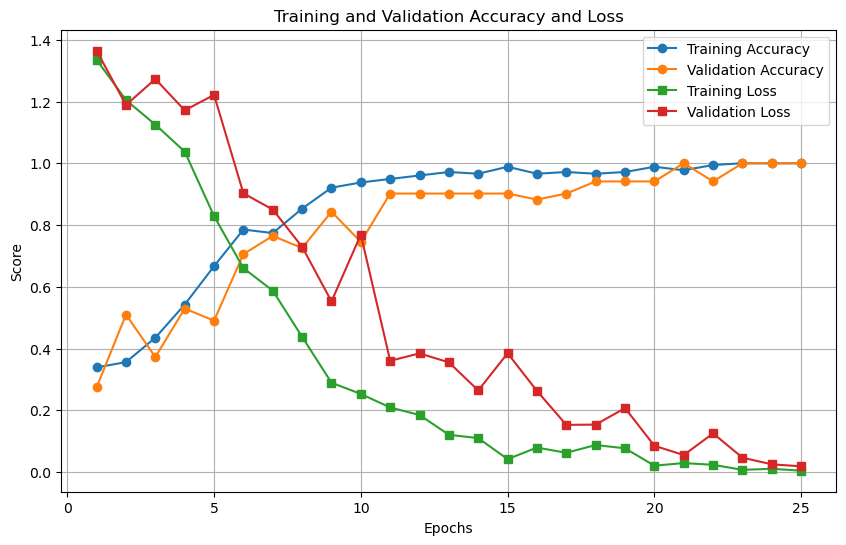

In [27]:
train_loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
train_accuracy = history_lstm.history['accuracy']
val_accuracy = history_lstm.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation accuracy and loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.plot(epochs, train_loss, label='Training Loss', marker='s')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')

plt.title('Training and Validation Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

#### Test the data and evaluate it using a confusion matrix and classification report

In [28]:
# Predict on test data
y_pred = lstm_model.predict(pp_X_test)
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(pp_y_test, y_pred_classes))

# Classification Report
print("Classification Report:")
print(classification_report(pp_y_test, y_pred_classes, digits=4))

# Weighted Metrics
f1_weighted = f1_score(pp_y_test, y_pred_classes, average='weighted')
precision_weighted = precision_score(pp_y_test, y_pred_classes, average='weighted')
recall_weighted = recall_score(pp_y_test, y_pred_classes, average='weighted')

print(f"Weighted F1 Score: {f1_weighted}")
print(f"Weighted Precision: {precision_weighted}")
print(f"Weighted Recall: {recall_weighted}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
Confusion Matrix:
[[9 0 0 0]
 [0 5 0 0]
 [0 0 9 0]
 [0 0 0 3]]
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         9
           1     1.0000    1.0000    1.0000         5
           2     1.0000    1.0000    1.0000         9
           3     1.0000    1.0000    1.0000         3

    accuracy                         1.0000        26
   macro avg     1.0000    1.0000    1.0000        26
weighted avg     1.0000    1.0000    1.0000        26

Weighted F1 Score: 1.0
Weighted Precision: 1.0
Weighted Recall: 1.0


## LSTM + CNN

In [33]:
# Define CNN + LSTM model
cnn_lstm_model = models.Sequential([
    layers.TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu'), input_shape=(61, 128, 128, 1)),
    layers.TimeDistributed(layers.MaxPooling2D((2, 2))),
    layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu')),
    layers.TimeDistributed(layers.MaxPooling2D((2, 2))),
    layers.TimeDistributed(layers.Flatten()),
    layers.LSTM(64, activation='tanh', return_sequences=False),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')
])

# Compile the model
cnn_lstm_model.compile(optimizer='rmsprop',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

cnn_lstm_model.summary()

/Users/jackmoses/miniconda3/envs/cpen355project/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_6              │ (None, 61, 126, 126,   │           160 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 61, 63, 63, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 61, 61, 61, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 61, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 61, 28800)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │     7,389,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,396,452 (28.22 MB)

 Trainable params: 7,396,452 (28.22 MB)

 Non-trainable params: 0 (0.00 B)

#### Fit the model to the per person training and validation data

In [34]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

history_cnn_lstm = cnn_lstm_model.fit(pp_X_train, pp_y_train,
                        epochs=10,
                        batch_size=3,
                        validation_data=(pp_X_val, pp_y_val),
                        callbacks=[early_stopping])

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 301s 5s/step - accuracy: 0.3407 - loss: 1.2448 - val_accuracy: 0.2353 - val_loss: 1.3280
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 293s 5s/step - accuracy: 0.4806 - loss: 1.0785 - val_accuracy: 0.3725 - val_loss: 1.2874
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 286s 5s/step - accuracy: 0.5869 - loss: 0.9605 - val_accuracy: 0.5098 - val_loss: 1.2088
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 284s 5s/step - accuracy: 0.6589 - loss: 0.7767 - val_accuracy: 0.6078 - val_loss: 1.0470
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 288s 5s/step - accuracy: 0.7871 - loss: 0.5548 - val_accuracy: 0.7451 - val_loss: 0.6898
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 286s 5s/step - accuracy: 0.9109 - loss: 0.2969 - val_accuracy: 0.7647 - val_loss: 0.5175
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 287s 5s/step - accuracy: 0.9152 - loss: 0.2469 - val_accuracy: 0.8431 - val_loss: 0.4404
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 294s 5s/step - accuracy: 0.9735 - loss: 0.1134 - val_accuracy: 0.9020 - v

#### Plot the training and validation accuracy and loss over each epoch to view the progression of the model

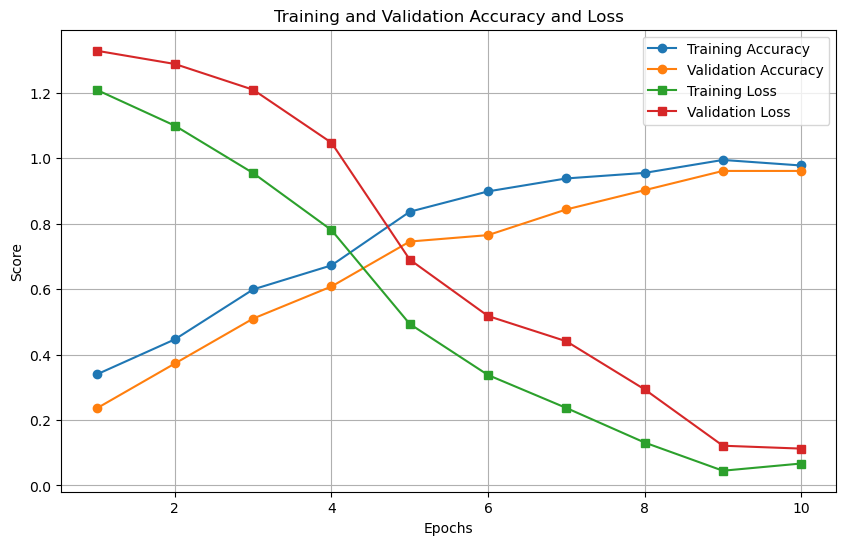

In [36]:
train_loss = history_cnn_lstm.history['loss']
val_loss = history_cnn_lstm.history['val_loss']
train_accuracy = history_cnn_lstm.history['accuracy']
val_accuracy = history_cnn_lstm.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation accuracy and loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.plot(epochs, train_loss, label='Training Loss', marker='s')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')

plt.title('Training and Validation Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

#### Test the model with the testing data and evaluate its performance

In [37]:
# Predict on test data
y_pred = cnn_lstm_model.predict(pp_X_test)
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(pp_y_test, y_pred_classes))

# Classification Report
print("Classification Report:")
print(classification_report(pp_y_test, y_pred_classes, digits=4))

# Weighted Metrics
f1_weighted = f1_score(pp_y_test, y_pred_classes, average='weighted')
precision_weighted = precision_score(pp_y_test, y_pred_classes, average='weighted')
recall_weighted = recall_score(pp_y_test, y_pred_classes, average='weighted')

print(f"Weighted F1 Score: {f1_weighted}")
print(f"Weighted Precision: {precision_weighted}")
print(f"Weighted Recall: {recall_weighted}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Confusion Matrix:
[[8 1 0 0]
 [0 5 0 0]
 [0 0 9 0]
 [0 0 0 3]]
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.8889    0.9412         9
           1     0.8333    1.0000    0.9091         5
           2     1.0000    1.0000    1.0000         9
           3     1.0000    1.0000    1.0000         3

    accuracy                         0.9615        26
   macro avg     0.9583    0.9722    0.9626        26
weighted avg     0.9679    0.9615    0.9622        26

Weighted F1 Score: 0.9621554915672562
Weighted Precision: 0.967948717948718
Weighted Recall: 0.9615384615384616
